# Notebook for model development
This notebook should be used to develop the model submodules locally. Note, that model relevant changes have to be made in the model subclasses. Additional code in this document is only used to get a better understanding of the dataflow and debug some outputs.

## 1: Set up environment
### Install dependencies
This will use the automation `install_dependencies.sh` in order to install necessary packages. Additional packages for development can be installed afterwards.

In [1]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gc
import sys
sys.path.append('../')

## 2: Get the data ready
In this step, the data will be imported and preprocessed.

### Download Dataset
The dataset has to be imported using the submodule `model/import_data.py`.

In [5]:
from create_dataset import create_dataset
from helpers.s3 import enable_local_dev as s3_enable_local_dev
from helpers.influx import enable_local_dev as influx_enable_local_dev

# Enable local development (use local path instead of internal docker path)
s3_enable_local_dev()
influx_enable_local_dev()

measurements = ['env_beige_default']
img_size = (None, 75, 100, 3)

dataset_id = "5e1530ab-ba18-42fa-8897-590f6ea833e5"
images, labels, uids = create_dataset(measurements, img_size)
max_input_value = 350

del dataset_id
_ = gc.collect()

### Inspect dataset

Number of images:  528
Labels from  1  to  249 



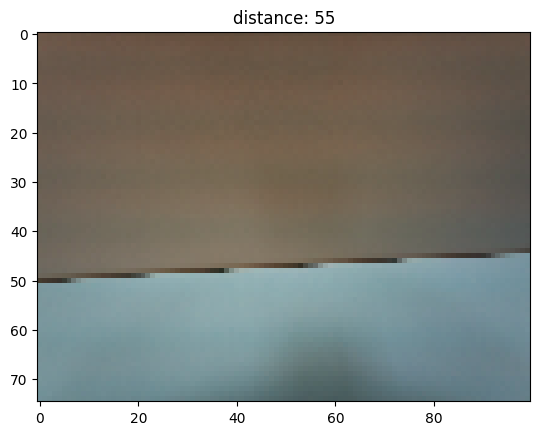

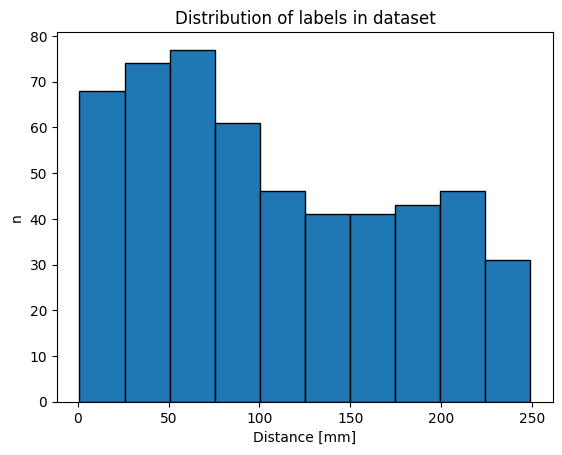

In [6]:
print("Number of images: ", images.shape[0])
print("Labels from ", np.min(labels), " to ", np.max(labels), "\n")

def plot_image(image, label):
  plt.imshow(image)
  plt.title(label)
  plt.show()

# Plot some images
num_images_to_plot = 1
for i in range(0, num_images_to_plot):
  plot_image(images[i], f"distance: {labels[i]}")

# Plot histogram of labels
plt.hist(labels, edgecolor='black')  # Erstelle das Histogramm mit 10 Bins
plt.title('Distribution of labels in dataset')
plt.xlabel('Distance [mm]')
plt.ylabel('n')
plt.show()

del num_images_to_plot, i
_ = gc.collect()

### Preprocess dataset
The dataset is preprocessed using the submodule `model/preprocess_data.py`.

In [ ]:
from preprocess_data import preprocess_data

test_split = 0.2
random_state = 0
train_x, train_y, train_uids, test_x, test_y, test_uids = \
    preprocess_data(images, labels, uids, test_split, random_state)

del images, labels, uids
_ = gc.collect()

In [ ]:
print("\nTrainingsdaten: ")
mean = np.mean(train_x)
std = np.std(train_x)
max = np.max(train_x)
min = np.min(train_x)
print(f"Anzahl: {train_x.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {train_x.shape[1]} x {train_x.shape[2]}")
print(f"Min Label: {np.min(train_y)}")
print(f"Max Label: {np.max(train_y)}")
print(f"Verschiedene Labels: {len(np.unique(train_y))}")

plot_image(train_x[0], f"distance: {train_y[0]}")

print("\nTestdaten: ")
mean = np.mean(test_x)
std = np.std(test_x)
max = np.max(test_x)
min = np.min(test_x)
print(f"Anzahl: {test_x.shape[0]}")
print(f"Durchschnittlicher Pixelwert: {mean:.2f}")
print(f"Standardabweichung der Pixelwerte: {std:.2f}")
print(f"Höchster Pixelwert: {max:.2f}")
print(f"Niedrigster Pixelwert: {min:.2f}")
print(f"Bildgröße (Höhe x Breite): {test_x.shape[1]} x {test_x.shape[2]}")
print(f"Min Label: {np.min(test_y)}")
print(f"Max Label: {np.max(test_y)}")
print(f"Verschiedene Labels: {len(np.unique(test_y))}")

plot_image(test_x[0], f"distance: {test_y[0]}")

# Plot histogram of labels
print("\nLabel distribution in training and test set:")
plt.hist([train_y, test_y], label=['Train', 'Test'],
          edgecolor='black', color=['blue', 'orange'])
plt.title('Distribution of labels in dataset')
plt.xlabel('Distance [mm]')
plt.ylabel('n')
plt.legend()
plt.show()

del mean, min, max, std
_ = gc.collect()

## 3: Model

### Create model
The model is created using `model/create_model.py`

In [ ]:
from create_model import create_model

model = create_model(test_x.shape, dropout=0.2, use_variation=None)

### Inspect model

In [ ]:
model.summary()

Optional: Plot model

In [ ]:
from keras.utils import plot_model  # type: ignore
plot_model(model, show_shapes=True, show_layer_names=True)

### Model training
The model is trained using `model_fit_model.py`
This should ideally be done using the workflow.

In [ ]:
from fit_model import fit_model

history = fit_model(
              model, train_x, train_y,
              optimizer='adam',
              loss="mean_squared_error",
              metrics=['mae'],
              epochs=50,
              batch_size=128
              )

In [ ]:
print(f"Final loss: {history.history['loss'][-1]:.4f}")
print(f"Final accuracy: {history.history['mae'][-1]:.4f}")

print(history.history)

# Plot training loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epopch')
plt.ylabel('Loss')

# Plot training accuracy
plt.figure(2)
plt.plot(history.history['mae'])
plt.title('Training Mean Average Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.show()

### Evaluate model
The model is evaluated using `model/evaluate_model.py`

In [ ]:
from evaluate_model import evaluate_model

test_loss, test_mae= evaluate_model(model, test_x, test_y)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_mae:.4f}')

#### Perform random predictions on the test set

In [ ]:
from random import randint

i = randint(0, test_x.shape[0])
img = test_x[i:i+1]
prediction = model.predict(img)
prediction_transformed = int(prediction[0][0]*max_input_value)
label_transformed = int(test_y[i]*max_input_value)
print("Prediction:", prediction_transformed)
print("Label:", label_transformed)

plot_image(test_x[i], f"Prediction: {prediction_transformed}, Label: {label_transformed}")

#### Get predictions with difference to label > threshold [mm]

In [ ]:
from tqdm import tqdm

threshold = 20


def predictOnDataset(X):
    print("Predicting dataset, please wait ...\n")
    predictions = np.zeros((len(X)), dtype=float)
    for i in tqdm(range(X.shape[0]), desc="Progress: ", ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} images predicted'):
        prediction = model.predict(X[i:i+1], verbose = 0)
        predictions[i] = prediction[0][0]
    print("\nPredicted labels von ", np.min(predictions), " bis ", np.max(predictions))

    return predictions


def getOutliers(labels, predictions, threshold):
# Filter predictions wich are to far away from the labels
    outlier_image_idices = np.array([], dtype=np.int32)
    for i, label in enumerate(labels):
        if abs(predictions[i] - label) > threshold:
            outlier_image_idices = np.append(outlier_image_idices, i)
    print("Number of outliers: ", outlier_image_idices.shape[0], " = ", len(outlier_image_idices)/len(labels)*100, "%")

    return outlier_image_idices


predictions = predictOnDataset(test_x)
predictions_mm = (predictions*max_input_value).astype(int)
labels_mm = (test_y*max_input_value).astype(int)
outliers = getOutliers(labels_mm, predictions_mm, threshold)

#### Plot outlier predictions

In [ ]:
for outlier in outliers:
    plot_image(test_x[outlier], f"Prediction: {predictions_mm[outlier]}, Label: {labels_mm[outlier]}")

### Save model

In [ ]:
model.save('model.keras')